# Gradient Descent

In [1]:
import math
import numpy as np
import random
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

## Sum of squares

In [2]:
def sum_of_squares(v):
    """computes the sum of squared elements in v"""
    return sum(v_i ** 2 for v_i in v)

Here's what the sum of squares function looks like in a nifty 3D plot. It's easy to guess that its global minimum is at the origin.

In [3]:
n=10
X = np.linspace(-6, 6, num=n)
Y = np.linspace(-6, 6, num=n)
U, V = np.meshgrid(X, Y)

In [4]:
Z = sum_of_squares((U,V))

Text(0.5,0,'z')

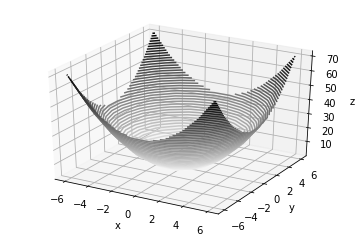

In [5]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

## Estimating the gradient

In [6]:
def partial_difference_quotient(f, v, i, epsilon=0.00001):
    """
    estimate partial derivative with respect to v_i of a function f at v
    """
    v0 = [(v_j-epsilon) if j==i else v_j for j, v_j in enumerate(v)]
    v1 = [(v_j+epsilon) if j==i else v_j for j, v_j in enumerate(v)]
    return (f(v1) - f(v0)) / (2*epsilon)

In [7]:
def estimate_gradient(f, v, epsilon=0.00001):
    return [partial_difference_quotient(f, v, i, epsilon) for i, _ in enumerate(v)]

In [8]:
estimate_gradient(sum_of_squares, (0.3, 0.3))

[0.6000000000006, 0.6000000000006]

As expected, the negative of the gradient points down hill towards the origin. The sides of the bowl get quickly steeper and thus the gradient larger as you get further away from the minimum.

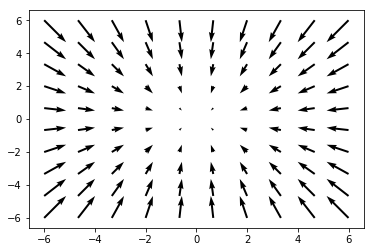

In [9]:
plt.quiver(X, Y,
           -partial_difference_quotient(sum_of_squares, (U,V), 0),
           -partial_difference_quotient(sum_of_squares, (U,V), 1))
plt.show()

## Gradient descent

Find the minimum by following the gradient.

In [10]:
def step(v, direction, step_size):
    """
    move step_size in the direction from v
    """
    return [v_i + step_size * direction_i for v_i, direction_i in zip(v, direction)]

In [11]:
def distance(v, w):
    return math.sqrt(sum((vi-wi)**2 for vi, wi in zip(v,w)))

In [12]:
tolerance = 0.0000001

In [13]:
v = [random.randint(-10,10) for i in range(3)]

In [14]:
print(v)

[7, -4, -5]


In [15]:
err = []
while True:
    err.append(sum_of_squares(v))
    gradient = estimate_gradient(sum_of_squares, v)
    next_v = step(v, gradient, -0.001)
    if distance(next_v, v) < tolerance:
        break
    v = next_v

Hey, we found zero... well, pretty close.

In [16]:
v

[3.6864996384880905e-05, -2.1065712219419555e-05, -2.6332140274573717e-05]

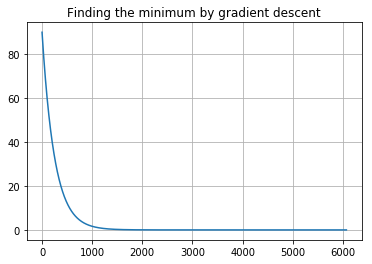

In [17]:
plt.plot(err)
plt.title('Finding the minimum by gradient descent')
plt.grid(True)
plt.show()

## Turning that into a function

In [18]:
def safe(f):
    """
    return a new function that's the same as f, except that it outputs
    infinity whenever f produces an error
    """
    def safe_f(*args, **kwargs):
        try:
            return f(*args, **kwargs)
        except:
            return float('inf')
    return safe_f

In [19]:
def minimize_batch(target_fn, gradient_fn, theta_0, tolerance=0.000001):
    """use gradient descent to find theta that minimizes target function"""
    
    step_sizes = [100, 10, 1, 0.1, 0.01, 0.001, 0.0001, 0.00001]
    theta = theta_0
    target_fn = safe(target_fn)
    value = target_fn(theta)
    values = []
    
    # set theta to initial value
    # safe version of target_fn
    # value we're minimizing
    while True:
        values.append(value)
        gradient = gradient_fn(theta)
        next_thetas = [np.array(step(theta, gradient, -step_size))
                       for step_size in step_sizes]

        # choose the one that minimizes the error function
        next_theta = min(next_thetas, key=target_fn)
        next_value = target_fn(next_theta)

        # stop if we're "converging"
        if abs(value - next_value) < tolerance:
            values.append(next_value)
            break
        else:
            theta, value = next_theta, next_value

    return theta, values

In [20]:
def est_gradient_sum_of_squares(v):
    return estimate_gradient(sum_of_squares, v)

In [21]:
n = 3
theta, values = minimize_batch(sum_of_squares,
                               est_gradient_sum_of_squares,
                               [random.randint(-10,10) for i in range(n)])

In [22]:
theta

array([0.        , 0.00162259, 0.00032452])

In [23]:
sum_of_squares(theta)

2.738119583396102e-06

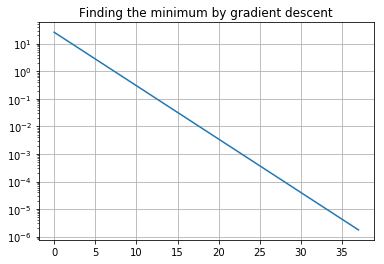

In [24]:
plt.semilogy(values)
plt.title('Finding the minimum by gradient descent')
plt.grid(True)
plt.show()

## Stochastic gradient descent

In [25]:
def in_random_order(data):
    """generator that returns the elements of data in random order"""
    # create a list of indexes
    indexes = [i for i, _ in enumerate(data)]
    random.shuffle(indexes)

    # return the data in that order
    for i in indexes:
        yield data[i]

In [26]:
print(list(in_random_order(range(20))))

[7, 13, 16, 2, 10, 14, 19, 0, 9, 5, 17, 11, 1, 6, 12, 15, 8, 3, 18, 4]


In [27]:
def vector_subtract(v, w):
    """subtracts corresponding elements"""
    return [v_i - w_i for v_i, w_i in zip(v, w)]

def scalar_multiply(c, v):
    """c is a number, v is a vector"""
    return [c * v_i for v_i in v]

def minimize_stochastic(target_fn, gradient_fn, x, y, theta_0, alpha_0=0.01):
    data = list(zip(x, y))
    
    # initial guess
    theta = theta_0
    
    # initial step size
    alpha = alpha_0
    
    # the minimum so far
    min_theta, min_value = None, float("inf")
    iterations_with_no_improvement = 0

    # if we ever go 100 iterations with no improvement, stop
    while iterations_with_no_improvement < 100:
        value = sum(target_fn(x_i, y_i, theta) for x_i, y_i in data)

        if value < min_value:
            # if we've found a new minimum, remember it
            # and go back to the original step size
            min_theta, min_value = theta, value
            iterations_with_no_improvement = 0
            alpha = alpha_0
        else:
            # otherwise we're not improving, so try shrinking the step size
            iterations_with_no_improvement += 1
            alpha *= 0.9

        # and take a gradient step for each of the data points
        for x_i, y_i in in_random_order(data):
            gradient_i = gradient_fn(x_i, y_i, theta)
            theta = vector_subtract(theta, scalar_multiply(alpha, gradient_i))

    return min_theta

The book defines this function on page 100 in Chapter 8, then doesn't use it until page 176 in Chapter 14 on linear regression. In between are 5 chapters full of good material that has nothing to do with gradient descent. My attention span is way too low to wait that long. Let's try this thing.

In [28]:
n = 1000
x = np.random.uniform(-2.0, 2.0, n)
y = 2.0 * x * x + 1.23456 * x + 4.5678 + np.random.normal(0.0, 1.0, n)

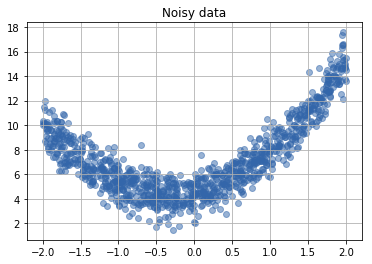

In [29]:
plt.scatter(x, y, marker='o', color='#3366aa80')
plt.title('Noisy data')
plt.grid(True)
plt.show()

### Fit by stochastic gradient descent
The coefficents we used above are `theta = (4.5678, 1.23456, 2.0)` ...but pretend we don't know that. Let's find the minimum by stochastic gradient descent.

In [30]:
def predict(theta, x):
    """
    theta[0] + theta[1] * x + theta[2] * x**2 + ...
    """
    return sum(theta_i * x**i for i, theta_i in enumerate(theta))

In [31]:
def error(theta, x, y):
    return (y - predict(theta, x))

In [32]:
def squared_error(x, y, theta):
    return error(theta, x, y)**2

In [33]:
def gradient_squared_error(x, y, theta):
    return [-2 * error(theta, x, y),
            -2 * error(theta, x, y) * x,
            -2 * error(theta, x, y) * x**2]

In [34]:
theta_hat = minimize_stochastic(squared_error, gradient_squared_error, x, y, theta_0=(1.0, 1.0, 1.0), alpha_0=0.01)
print(theta_hat)

[4.545450794964968, 1.2749009174949177, 2.0369191639216453]


...not a bad job of recovering the coefficients. And the fit to the data looks pretty good.

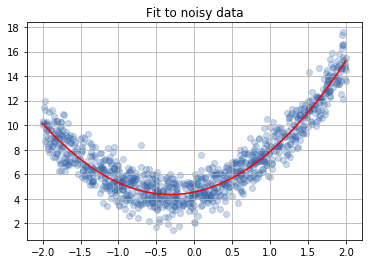

In [35]:
x_ordered = np.linspace(-2, 2, num=n)

plt.scatter(x, y, marker='o', color='#3366aa40')
plt.plot(x_ordered, predict(theta_hat, x_ordered), 'r-')
plt.title('Fit to noisy data')
plt.grid(True)
plt.show()